In [2]:
import networkx as nx
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [3]:
vocab_size = 10000
max_length = 200
embedding_dim = 128
lstm_units = 128
epochs = 5
batch_size = 32

In [4]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

In [5]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(units=lstm_units))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

C:\Users\21118\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.2)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 223ms/step - accuracy: 0.7158 - loss: 0.5445 - val_accuracy: 0.8290 - val_loss: 0.3873
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 124s 198ms/step - accuracy: 0.8766 - loss: 0.3039 - val_accuracy: 0.8658 - val_loss: 0.3262
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 132ms/step - accuracy: 0.9139 - loss: 0.2198 - val_accuracy: 0.7750 - val_loss: 0.4554
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 108s 173ms/step - accuracy: 0.9373 - loss: 0.1688 - val_accuracy: 0.8668 - val_loss: 0.3591
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 114s 128ms/step - accuracy: 0.9615 - loss: 0.1105 - val_accuracy: 0.8508 - val_loss: 0.4252


In [7]:
test_loss, test_accuracy = model.evaluate(X_test,y_test)
print(f"Test Accuracy:{test_accuracy:.4f}, Test Loss:{test_loss:.4f}")

y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.8500 - loss: 0.4373
Test Accuracy:0.8525, Test Loss:0.4276
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step


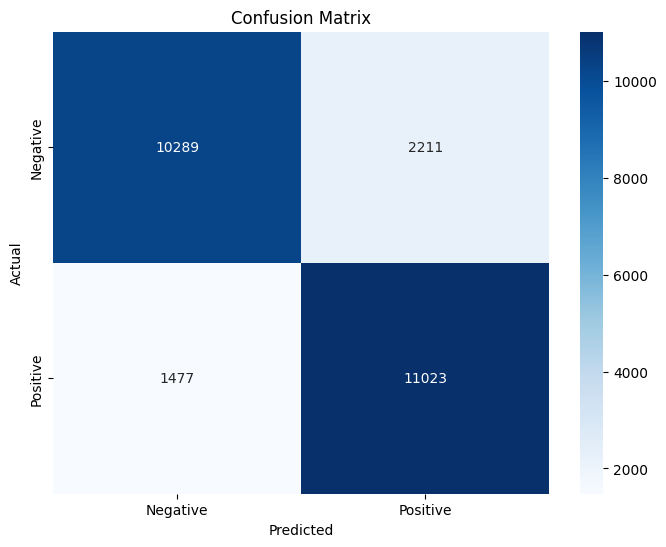

In [8]:
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix, annot = True, cmap = 'Blues', fmt = 'd', xticklabels = ['Negative', 'Positive'], yticklabels = ['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [9]:
TN, FP, FN, TP = conf_matrix.ravel()
accuracy_cm = (TN + TP) / (TN + TP + FN + FP)
precision_cm = TP / (TP + FP)
recall_cm = TP / (TP + FN)
f1_score_cm = 2 * (precision_cm * recall_cm) / (precision_cm + recall_cm)
print(f"Accuracy: {accuracy_cm:.4f}")
print(f"Precision: {precision_cm:.4f}")
print(f"Recall: {recall_cm:.4f}")
print(f"F1 Score: {f1_score_cm:.4f}")

Accuracy: 0.8525
Precision: 0.8329
Recall: 0.8818
F1 Score: 0.8567


In [10]:
model.save('sentiment_rnn_model.h5')

In [11]:
word_index = imdb.get_word_index()
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.word_index = word_index
with open('tokenizer.pickle','wb') as handle:
    pickle.dump(tokenizer,handle)

print("Model and tokenizer saved successfully!")

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model and tokenizer saved successfully!


In [12]:
def perform_sentiment_analysis(graph,model_path,tokenizer_path,max_length):
    """
    Perform sentiment analysis on a network graph
    using a pre-trained RNN model.
    Parameters:
    - graph (nx.Graph): NetworkX graph with 'text'
    attributes on nodes.
    - model_path (str): Path to the pre-trained RN
    N model file (e.g., 'sentiment_rnn_model.h5')
    - tokenizer_path (str): Path to the saved toke
    nizer file (e.g., 'tokenizer.pickle').
    - max_length (int): Maximum sequence length fo
    r padding (must match the model's training).
    Returns:
    - nx.Graph: The input graph with 'sentiment' a
    ttributes added to nodes.
    """
    texts = [data['text'] for _,data in graph.nodes(data=True)]
    if not texts:
        raise ValueError("Graph is empty or 'text' attribute is missing.")
    
    with open(tokenizer_path,'rb') as handle:
        tokenizer = pickle.load(handle)
    
    
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences,maxlen=max_length)
    model = load_model(model_path)
    
    predictions = model.predict(padded_sequences)
    sentiments = ['positive' if p > 0.5 else 'negative' for p in predictions.flatten()]

    for node, sentiment in zip(graph.nodes(), sentiments):
        graph.nodes[node]['sentiment'] = sentiment

    return graph

In [13]:
if __name__ == "__main__":
    # Create a sample graph
    G = nx.Graph()
    G.add_node(1, text="This is terrible.")
    G.add_node(2, text="It's absolutely amazing.")
    # Specify paths and parameters (replace with actual paths)
    model_path = 'sentiment_rnn_model.h5'
    tokenizer_path = 'tokenizer.pickle'
    max_length = 200 # Must match the model's training configuration
    try:
    # Perform sentiment analysis
        G = perform_sentiment_analysis(G, model_path, tokenizer_path, max_length)
    except ValueError as e:
        print(f"Error: {e}")
    
    # Visualize the sentiment analysis results
    pos_count = sum([1 for _, data in G.nodes(data=True) if data['sentiment'] == 'positive'])
    neg_count = sum([1 for _, data in G.nodes(data=True) if data['sentiment'] == 'negative'])
    total_count = len(G.nodes())

    pos_percent = (pos_count / total_count) * 100
    neg_percent = (neg_count / total_count) * 100

    print(f"Positive Sentiment: {pos_percent:.2f}%")
    print(f"Negative Sentiment: {neg_percent:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
Positive Sentiment: 100.00%
Negative Sentiment: 0.00%
